In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install glob2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from glob import glob
import os
import pandas as pd
path = "/content/drive/MyDrive/Iqram Sir/Fitabase data pulls - seperate"

#Function

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

def get_content(patient_folder_adrs):

  post_adrs = sorted(glob(patient_folder_adrs+"/*"))[0]
  

  pre_adrs = sorted(glob(patient_folder_adrs+"/*"))[1]

  for i in glob(post_adrs+"/*"):
    content = i.split("_")
    if "1min" in content:
      post_1min = i
    if "minuteCaloriesNarrow" in content:
      post_cal = i
    if "minuteMETsNarrow" in content:
      post_met = i


  for i in glob(pre_adrs+"/*"):
    content = i.split("_")
    if "1min" in i.split("_"):
      pre_1min = i
    if "minuteCaloriesNarrow" in content:
      pre_cal = i
    if "minuteMETsNarrow" in content:
      pre_met = i
 
  return post_1min, post_cal,post_met, pre_1min, pre_cal, pre_met




def plot(dataFrame,hr_aee = False):
  Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
  X = dataFrame["aEE(kJ/min)"].values.reshape(-1, 1)
  reg = LinearRegression().fit(X, Y)
  m = reg.coef_[0]
  c = reg.intercept_
  
  fig = plt.figure(figsize=(13,8))
  ax = fig.add_subplot()
  fig.subplots_adjust(top=0.85)

  # Set titles for the figure and the subplot respectively
  #fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')
  if hr_aee == True:
    ax.set_title('Max HR & aEE',fontweight='bold')
  else:
    ax.set_title('Max HR',fontweight='bold')

  ax.scatter(X, Y)

  high_y = Y.max()

  high_x = (high_y-c)/m

  rang_y=[Y.min(),high_y]

  ax.plot((rang_y-c)/m, rang_y, color = "red")

  ax.scatter(high_x, high_y, color='green')
  ax.annotate('(aEEMax,HRMax)', xy=(high_x, high_y), xytext=(high_x-5, high_y+10),fontweight='bold')
  ax.annotate("("+str(round(high_x[0],2))+","+str(high_y)+")", xy=(high_x, high_y), xytext=(high_x-3, high_y+5),fontweight='bold',color = 'purple')


  if hr_aee == True:
    ax.set_xlabel("aEE_MAX(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR_MAX(BPM)",fontweight='bold',fontsize=12)
  else:
    ax.set_xlabel("aEE(kJ/min)",fontweight='bold',fontsize=12)
    ax.set_ylabel("HR(BPM)",fontweight='bold',fontsize=12)

  ax.axis([0, high_x+10, 0, high_y+30])

  ax.grid()
  plt.show()




def signle_sample(df_1min, df_cal,df_met):
  list_1 = list(df_1min["Time"])
  list_2 = list(df_cal["ActivityMinute"])
  #df_met = mets_minute_refine(df_met,min)
  list_3 = list(df_met["ActivityMinute"])


  hr = []
  aee = []
  time = []
  mets = []

  if len(list_1)>len(list_2):
    for i in tqdm(list_1):
      if i in list_2 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  else:
    for i in tqdm(list_2):
      if i in list_1 and i in list_3:
        hr.append(list(df_1min.query("Time == '"+i+"'")['Value'])[0])
        aee.append(list(df_cal.query("ActivityMinute == '"+i+"'")['Calories'])[0]*4.184)
        mets.append(list(df_met.query("ActivityMinute == '"+i+"'")['METs'])[0])
        time.append(i)

  d={
    "Time" : time,
     "HR(BPM)" : hr,
     "aEE(kJ/min)":aee,
     "METs" : mets
  }

  dataFrame = pd.DataFrame.from_dict(d)
  return dataFrame



def max_hr_aee(dataFrame):
  Y = dataFrame["HR(BPM)"].values.reshape(-1, 1)
  X = dataFrame["aEE(kJ/min)"].values.reshape(-1, 1)
  reg = LinearRegression().fit(X, Y)
  m = reg.coef_[0]
  c = reg.intercept_
  hr_mx = Y.max()
  aee_mx = (hr_mx-c)/m
  return hr_mx, round(aee_mx[0],2)



def test_signle_sample(data,df_1min,df_cal,df_met):
  total_row = data.shape[0]
  print("Total DataRow: ",total_row)

  err_row=[]

  for i in tqdm(range(total_row)):
    print(data["Time"][i], data['HR(BPM)'][i],round(data['aEE(kJ/min)'][i],2),data['METs'][i])

    hr = list(df_1min.query("Time == '"+data["Time"][i]+"'")['Value'])[0]
    cal = round(list(df_cal.query("ActivityMinute == '"+data["Time"][i]+"'")['Calories'])[0],2)
    mets = list(df_met.query("ActivityMinute == '"+data["Time"][i]+"'")['METs'])[0]
    print(hr,round(cal*4.184,2),mets)
    print("------------------------------------------------------------")

    if hr != data['HR(BPM)'][i] or cal != round(data['aEE(kJ/min)'][i]/4.184,2) or mets != data['METs'][i]:
      err_row.append((data["Time"][i],i))
  return err_row







def range_list(k):
  list_of = []
  main_list = []

  for i in range(len(k)-1):
 
    if k[i+1]-k[i] == 1:
      list_of.append(k[i])
    else:
      list_of.append(k[i])
      main_list.append(list_of)
      list_of=[]
    if i == len(k)-2:
      if k[i+1]-k[i] == 1:
        list_of.append(k[i+1])
        main_list.append(list_of)
      else:
        main_list.append([k[i+1]])
  
  return main_list






def mets_minute_refine(data,minutes,upper_lim,lower_lim):

  mets_none = []
  mets_more = []
  for i in range(data.shape[0]):

    if lower_lim< data["METs"][i] <= upper_lim:
    #if data["METs"][i] > 10:
      mets_more.append(i)
    else:
      mets_none.append(i)

  main_l = range_list(mets_more)

  removable_list = []
  for i in range(len(main_l)-1):
    if len(main_l[i]) < minutes+1:
      for j in main_l[i]:
        removable_list.append(j)

  df1=data.drop(data.index[mets_none+removable_list]).reset_index()
  return df1





from datetime import datetime

def formate24(t):
  time = t.split(" ")
  m2 = time[1]+" "+time[2]
  in_time = datetime.strptime(m2, "%I:%M:%S %p")
  out_time = datetime.strftime(in_time, "%H:%M:%S")
  return out_time


def dif_min(start_time, end_time):
  t1 = datetime.strptime(start_time, "%H:%M:%S")
  t2 = datetime.strptime(end_time, "%H:%M:%S")

  delta = t2 - t1

  return delta.total_seconds()/60







def time_limit_check(test_data,min_limit):
  time_diff_list = []
  let = range_list(list(test_data['index']))
  for i in tqdm(let):

    start_time = formate24(list(test_data.query("index == "+str(i[0])+"")['Time'])[0])
    end_time = formate24(list(test_data.query("index == "+str(i[-1])+"")['Time'])[0])
    diff = dif_min(start_time,end_time)
    if diff < min_limit:
      time_diff_list.append(i)
  
  return time_diff_list


def single_segment_refine(single_list,min_limit):
  temp = []
  main = []
  if len(single_list)>1:
    for i in range(len(single_list)-1):
      k = formate24(list(test_data.query("index == "+str(single_list[i+1])+"")['Time'])[0])
      l = formate24(list(test_data.query("index == "+str(single_list[i])+"")['Time'])[0])
      diff = dif_min(l,k)
      #print(k,l,diff)
      if diff == 1 or diff == -1439.0:
        temp.append(single_list[i])
        flage = 1
      else:
        temp.append(single_list[i])
        if len(temp) >= min_limit+1:
          main.append(temp)
        temp=[]
        flage = 0

    if flage == 1:
      if len(temp) >= min_limit+1:
        k = formate24(list(test_data.query("index == "+str(single_list[i+1])+"")['Time'])[0])
        l = formate24(list(test_data.query("index == "+str(single_list[i])+"")['Time'])[0])
        diff = dif_min(l,k)
        if diff == 1 or diff == -1439.0:
          temp.append(single_list[i+1])
          main.append(temp)
        else:
          main.append(temp)


  return main


def final_refination(data,min_lim):
  min_lim = 5
  print("Time Limit Checking:")
  time_diff_list = time_limit_check(data,min_lim)
  print()

  removeable_list=[]

  print("Unwanted index list making:")
  for i in tqdm(time_diff_list):
  # print(i)
    lis = single_segment_refine(i,min_lim)
    combined = []

    for j in lis:
      combined=combined+j


    for k in i:
      if k not in combined:
        removeable_list.append(k)
  

  print()
  print("Refining Dataset:")

  for i in tqdm(removeable_list):
    data.drop(data.loc[data['index']==i].index, inplace=True)

  data.reset_index()

  return data



#Sample Test for single subject

In [5]:
subject = '001-JV'



for i in glob(path+"/*"):
  #get_contenct(i)
  if subject in i.split("/"):
    Post_1min,Post_cal,Post_met, Pre_1min,Pre_cal,Pre_met = get_content(i)

df_post_1min = pd.read_csv(Post_1min)
df_post_cal = pd.read_csv(Post_cal)
df_post_met = pd.read_csv(Post_met)

df_pre_1min = pd.read_csv(Pre_1min)
df_pre_cal = pd.read_csv(Pre_cal)
df_pre_met = pd.read_csv(Pre_met)



##Pre Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `pre condition`.<br>


In [33]:
minute_limit = 15
d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)

  0%|          | 0/80640 [00:00<?, ?it/s]

In [34]:
#@title Select METs Ranges { run: "auto" }
option = "25 \u003C METs \u003C= 45" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



You selected 25 < METs <= 45
Upper Limit:  45
Lower Limit:  25
Activity:  Moderate_Activity


###Refining

In [35]:
epoch = 15      #set the epoch number

test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"pre"+"_"+activity+".csv",index=False)

Time Limit Checking:


  0%|          | 0/2 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/1 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/2 [00:00<?, ?it/s]

###Ploting

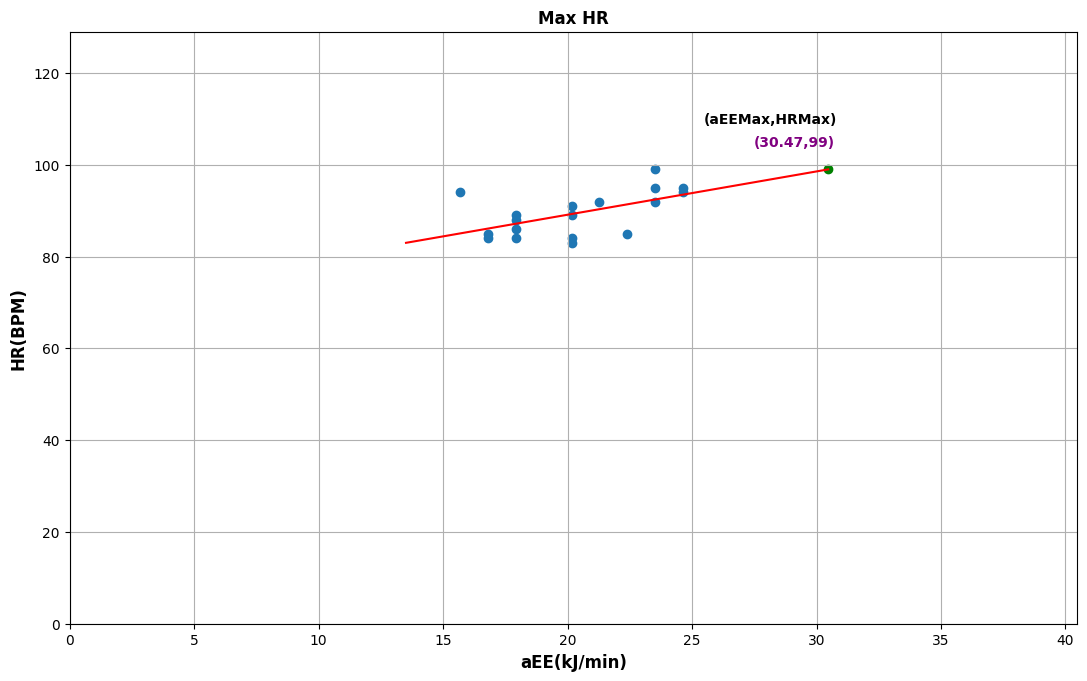

In [36]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(126, 70.39)

##Post Regression Line
<font color = 'blue'>Details:</font> This section will plot the regression line of `post condition`.<br>


In [6]:
d = signle_sample(df_post_1min,df_post_cal,df_post_met)

  0%|          | 0/50400 [00:00<?, ?it/s]

In [ ]:
#@title Select METs Ranges { run: "auto" }
option = "0 \u003C METs \u003C= 10" #@param ["0 < METs <= 10","10 < METs <= 25" ,"25 < METs <= 45", "45 < METs <=60","60<METs"]
print('You selected', option)

if option == "0 \u003C METs \u003C= 10":
  upper_lim = 10
  lower_lim = 0
  activity = "Resting"

elif option == "10 \u003C METs \u003C= 25":
  upper_lim = 45
  lower_lim = 25
  activity = "Light_Activity"


elif option == "25 \u003C METs \u003C= 45":
  upper_lim = 45
  lower_lim = 25
  activity = "Moderate_Activity"

elif option == "45 \u003C METs \u003C=60":
  upper_lim = 60
  lower_lim = 45
  activity = "Heavy_Activity"

elif option == "60\u003CMETs":
  upper_lim = 10000
  lower_lim = 60
  activity = "Heavy_Activity"

print("Upper Limit: ",upper_lim)
print("Lower Limit: ",lower_lim)
print("Activity: ",activity)



###Refining

In [ ]:
epoch = 15        #set the epoch number

test_data = mets_minute_refine(d, epoch,upper_lim,lower_lim)
final_data = final_refination(test_data,epoch)
#final_data.to_csv(subject+"_"+"post"+"_"+activity+".csv",index=False)

###Ploting

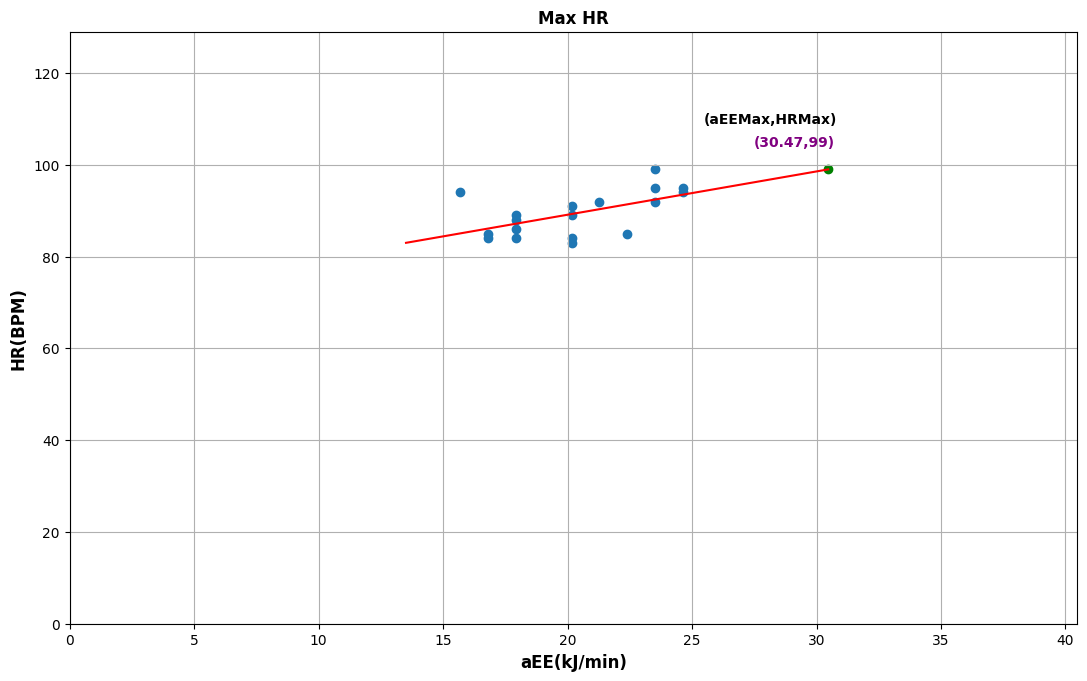

In [15]:
plot(final_data)

In [ ]:
max_hr_aee(final_data)

(122, 64.41)

#Dataset Creation with all `HR_MAX` and `aEE_MAX` values of all patients.

In [ ]:
file_save_destination = '/content/drive/MyDrive/Iqram Sir/test_fitabase/Test_HR_aEE_MAX.csv'

In [ ]:
from tqdm.notebook import tqdm



minute_limit = 5

if os.path.exists(file_save_destination)==False:
  main_dict = {
      "Patient_Id" : [],
      "Condition" : [],
      "HR_MAX(BPM)" : [],
      "aEE_MAX(kJ/min)": []
  }

  df = pd.DataFrame.from_dict(main_dict)
  df.to_csv(file_save_destination,index=False)



p_id = []
condition = []
hr_max = []
aee_max = []

for i in tqdm(sorted(glob(path+"/*"))):
  test_dataset = pd.read_csv(file_save_destination)
  count = 0
  print()
  print()
  sub =  os.path.basename(i)
  print("Subject processing: ",sub)
  Post_1min, Post_cal,Post_met, Pre_1min, Pre_cal,Pre_met = get_content(i)

  if 'pre' not in list(kj.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('pre')
    df_pre_1min = pd.read_csv(Pre_1min)
    df_pre_cal = pd.read_csv(Pre_cal)
    df_pre_met = pd.read_csv(Pre_met)
    print("Pre Condition In Process:")
    d = signle_sample(df_pre_1min,df_pre_cal,df_pre_met)
    test_data = mets_minute_refine(d, minute_limit)
    final_data = final_refination(test_data,minute_limit)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)

    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['pre'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)
    print("Pre Condition Process Complete...")


  if 'post' not in list(kj.query("Patient_Id == '"+sub+"'")['Condition']):
    p_id.append(sub)
    condition.append('post')
    df_post_1min = pd.read_csv(Post_1min)
    df_post_cal = pd.read_csv(Post_cal)
    df_post_met = pd.read_csv(Post_met)
    print("Post Condition In Process:")
    d = signle_sample(df_post_1min,df_post_cal,df_post_met)
    test_data = mets_minute_refine(d, minute_limit)
    final_data = final_refination(test_data,minute_limit)
    h,a = max_hr_aee(final_data)
    hr_max.append(h)
    aee_max.append(a)
    print("Post Condition Process Complete...")
    print()

    print("Processing Complete.....")
    print("------------------------------------------------------------------------")

    temp_dict = {
    "Patient_Id" : [sub],
    "Condition" : ['post'],
    "HR_MAX(BPM)" : [h],
    "aEE_MAX(kJ/min)": [a]
    }
    temp_df = pd.DataFrame(temp_dict)
    temp_df.to_csv(file_save_destination, mode='a', index=False, header=False)


print("Dataset creation complete......")

  0%|          | 0/36 [00:00<?, ?it/s]



Subject processing:  001-JV


Subject processing:  002-JR


Subject processing:  003-ES
Pre Condition In Process:


  0%|          | 0/14400 [00:00<?, ?it/s]

Time Limit Checking:


  0%|          | 0/128 [00:00<?, ?it/s]


Unwanted index list making:


  0%|          | 0/2 [00:00<?, ?it/s]


Refining Dataset:


  0%|          | 0/1 [00:00<?, ?it/s]

Pre Condition Process Complete...
Post Condition In Process:


  0%|          | 0/48960 [00:00<?, ?it/s]